In [1]:
import sqlite3
from collections import defaultdict
from pprint import pprint

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from attr import attributes
from pygments.lexers import q


In [2]:
# SETUP
DB_PATH = "1_after_cleaning_databases/1000_devices_cleaned.db"

# to get sensible output
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)

In [3]:
# find out how many unique session_ids there are in the database
conn = sqlite3.connect(DB_PATH)
query = "SELECT DISTINCT session_id FROM css_attribute"
session_ids = pd.read_sql(query, conn)
conn.close()
# remove duplicates
session_ids = session_ids.drop_duplicates(subset=['session_id'])
# count the number of unique session_ids
session_ids_count = session_ids['session_id'].count()
print(f"Number of unique session_ids: {session_ids_count}")

Number of unique session_ids: 1716


In [4]:
# find all session_ids that don't have User-Agent attribute
conn = sqlite3.connect(DB_PATH)
query = """
SELECT DISTINCT session_id, attribute
FROM css_attribute
WHERE session_id NOT IN (
    SELECT DISTINCT session_id
    FROM css_attribute
    WHERE attribute = 'User-Agent'
)
"""
missing_session_ids = pd.read_sql(query, conn)
conn.close()
# remove duplicates
missing_session_ids = missing_session_ids.drop_duplicates(subset=['session_id'])

for session, group in missing_session_ids.groupby('session_id'):
    print(f"========= Session ID: {session} =========")
    # get all attributes for this session
    attributes = group['attribute'].unique()
    print(f"Present attributes: {attributes}")

In [5]:
conn = sqlite3.connect(DB_PATH)
query = "SELECT session_id, attribute, value, source FROM css_attribute"
df = pd.read_sql(query, conn)
conn.close()

In [6]:
# Expected attributes for each session
expected_envs = {f"env-{i}-width" for i in range(1, 15) if i != 4} | {f"env-{i}-height" for i in range(1, 15) if i != 4}
expected_envs

{'env-1-height',
 'env-1-width',
 'env-10-height',
 'env-10-width',
 'env-11-height',
 'env-11-width',
 'env-12-height',
 'env-12-width',
 'env-13-height',
 'env-13-width',
 'env-14-height',
 'env-14-width',
 'env-2-height',
 'env-2-width',
 'env-3-height',
 'env-3-width',
 'env-5-height',
 'env-5-width',
 'env-6-height',
 'env-6-width',
 'env-7-height',
 'env-7-width',
 'env-8-height',
 'env-8-width',
 'env-9-height',
 'env-9-width'}

In [7]:
# get list of the sessions made by the browserstack that were made by automatic tests

## Get all records with source browserstack, get their session_id, and make it a unique list
browserstack_sessions = df[df['source'] == 'browserstack']['session_id'].unique()

## using list of session_ids get all records for them
filtered_df = df[df['session_id'].isin(browserstack_sessions)]

In [8]:
# Group by session and check missing attributes
missing_data = {}
os_mistakes_count = defaultdict(int)
os_version_mistakes_count = defaultdict(int)
browser_mistakes_count = defaultdict(int)
browser_version_mistakes_count = defaultdict(int)
os_browser_combinations = defaultdict(set)
browser_and_version_mistakes_count = defaultdict(int)

for session, group in filtered_df.groupby('session_id'):
    attributes = set(group['attribute'])
    missing_attrs = expected_envs - attributes
    if missing_attrs:
        # Extract OS, OS Version, Browser, and Browser Version
        os_value = group[group['attribute'] == 'os']["value"].values[0] if not group[group['attribute'] == 'os'].empty else "Unknown"
        os_version = group[group['attribute'] == 'os_version']["value"].values[0] if not group[group['attribute'] == 'os_version'].empty else "Unknown"
        browser = group[group['attribute'] == 'browser']["value"].values[0] if not group[group['attribute'] == 'browser'].empty else "Unknown"
        browser_version = group[group['attribute'] == 'browser_version']["value"].values[0] if not group[group['attribute'] == 'browser_version'].empty else "Unknown"

        os_mistakes_count[os_value] += 1
        os_version_mistakes_count[os_version] += 1
        browser_mistakes_count[browser] += 1
        browser_version_mistakes_count[browser_version] += 1
        browser_and_version_mistakes_count[(browser, browser_version)] += 1

        os_browser_combinations[(os_value, os_version, browser, browser_version)].add(session)

        missing_data[session] = {
            "missing": list(missing_attrs),
            "os": os_value,
            "os_version": os_version,
            "browser": browser,
            "browser_version": browser_version
        }

# sort all those defaultdicts descending by values
os_mistakes_count = dict(sorted(os_mistakes_count.items(), key=lambda item: item[1], reverse=True))
os_version_mistakes_count = dict(sorted(os_version_mistakes_count.items(), key=lambda item: item[1], reverse=True))
browser_mistakes_count = dict(sorted(browser_mistakes_count.items(), key=lambda item: item[1], reverse=True))
browser_version_mistakes_count = dict(sorted(browser_version_mistakes_count.items(), key=lambda item: item[1], reverse=True))
os_browser_combinations = dict(sorted(os_browser_combinations.items(), key=lambda item: item[1], reverse=True))
browser_and_version_mistakes_count = dict(sorted(browser_and_version_mistakes_count.items(), key=lambda item: item[1], reverse=True))


In [9]:
os_mistakes_count

{'ios': 47, 'OS X': 3, 'android': 2}

In [10]:
os_version_mistakes_count

{'18.0': 8,
 '18.3': 6,
 '16.0': 6,
 '17.5': 4,
 '17.1': 4,
 '17.0': 4,
 '16.4': 3,
 '16.3': 3,
 '16.2': 2,
 '18.1': 2,
 '17.3': 2,
 '16.5': 2,
 '7.0': 2,
 '18.2': 1,
 'Big Sur': 1,
 'Mojave': 1,
 'Sequoia': 1}

In [11]:
browser_mistakes_count

{'chrome': 49, 'firefox': 2, 'chrome_android': 1}

In [12]:
browser_version_mistakes_count

{'unknown': 49, '129.0': 1, '110.0': 1, '138.0 beta': 1}

In [13]:
# pretty print default dict with data sorted by value descending
browser_and_version_mistakes_count

{('chrome', 'unknown'): 48,
 ('firefox', '129.0'): 1,
 ('chrome', '110.0'): 1,
 ('chrome_android', 'unknown'): 1,
 ('firefox', '138.0 beta'): 1}

In [14]:
# Display session ids with missing data
for session, details in missing_data.items():
    print(f"========= Session ID: {session} =========")
    print(f"OS: {details['os']}")
    print(f"OS Version: {details['os_version']}")
    print(f"Browser: {details['browser']}")
    print(f"Browser Version: {details['browser_version']}")
    print("Missing Attributes:", details["missing"])

========= Session ID: 008d5537-1e12-48a5-a32f-ce831b21c74e =========
OS: ios
OS Version: 16.2
Browser: chrome
Browser Version: unknown
Missing Attributes: ['env-8-width']
========= Session ID: 0d1019c7-41b0-4d12-a44e-1c9a02b403a3 =========
OS: ios
OS Version: 18.1
Browser: chrome
Browser Version: unknown
Missing Attributes: ['env-8-width']
========= Session ID: 101ed6f8-166a-44ba-95a3-5485bcf6b62e =========
OS: ios
OS Version: 17.5
Browser: chrome
Browser Version: unknown
Missing Attributes: ['env-8-width']
========= Session ID: 14af54d1-dc01-491f-bd29-5cf3337266e5 =========
OS: ios
OS Version: 16.4
Browser: chrome
Browser Version: unknown
Missing Attributes: ['env-8-width']
========= Session ID: 14b79011-7079-4025-b1bf-6901a8f6227b =========
OS: ios
OS Version: 18.3
Browser: chrome
Browser Version: unknown
Missing Attributes: ['env-8-width']
========= Session ID: 174e3ed0-ebc6-4ac0-837d-5a123e6270c2 =========
OS: ios
OS Version: 18.3
Browser: chrome
Browser Version: unknown
Missing At

In [15]:
print("\nOS, OS Version, Browser, and Browser Version combinations with issues:")
for (os_value, os_version, browser, browser_version), sessions in os_browser_combinations.items():
    print(f"OS: {os_value}, OS Version: {os_version}, Browser: {browser}, Browser Version: {browser_version}, Affected Sessions: {len(sessions)}")

print("\nBrowser and Browser Version combinations with counts:")
browser_version_counts = Counter()

for (os_value, os_version, browser, browser_version), sessions in os_browser_combinations.items():
    browser_version_counts[(browser, browser_version)] += len(sessions)

for (browser, browser_version), count in browser_version_counts.items():
    print(f"Browser: {browser}, Browser Version: {browser_version}, Count: {count}")


OS, OS Version, Browser, and Browser Version combinations with issues:
OS: ios, OS Version: 16.2, Browser: chrome, Browser Version: unknown, Affected Sessions: 2
OS: ios, OS Version: 18.1, Browser: chrome, Browser Version: unknown, Affected Sessions: 2
OS: ios, OS Version: 17.5, Browser: chrome, Browser Version: unknown, Affected Sessions: 4
OS: ios, OS Version: 16.4, Browser: chrome, Browser Version: unknown, Affected Sessions: 3
OS: ios, OS Version: 18.3, Browser: chrome, Browser Version: unknown, Affected Sessions: 6
OS: ios, OS Version: 16.0, Browser: chrome, Browser Version: unknown, Affected Sessions: 6
OS: ios, OS Version: 18.0, Browser: chrome, Browser Version: unknown, Affected Sessions: 8
OS: ios, OS Version: 18.2, Browser: chrome, Browser Version: unknown, Affected Sessions: 1
OS: ios, OS Version: 17.3, Browser: chrome, Browser Version: unknown, Affected Sessions: 2
OS: ios, OS Version: 17.1, Browser: chrome, Browser Version: unknown, Affected Sessions: 4
OS: OS X, OS Versi

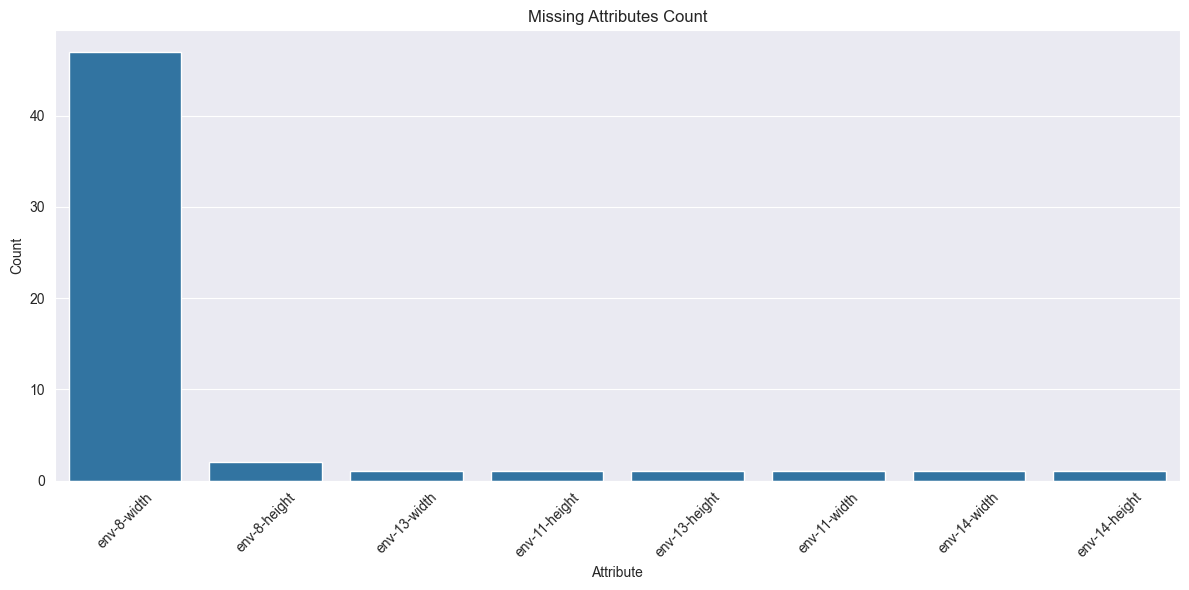

In [16]:
# from missing_data create a histogram of missing attributes
missing_counts = Counter()
for details in missing_data.values():
    for attr in details["missing"]:
        missing_counts[attr] += 1
# Create a DataFrame for plotting
missing_df = pd.DataFrame(missing_counts.items(), columns=['Attribute', 'Count'])
# Sort the DataFrame by Count
missing_df = missing_df.sort_values(by='Count', ascending=False)
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=missing_df, x='Attribute', y='Count')
plt.xticks(rotation=45)
plt.title('Missing Attributes Count')
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


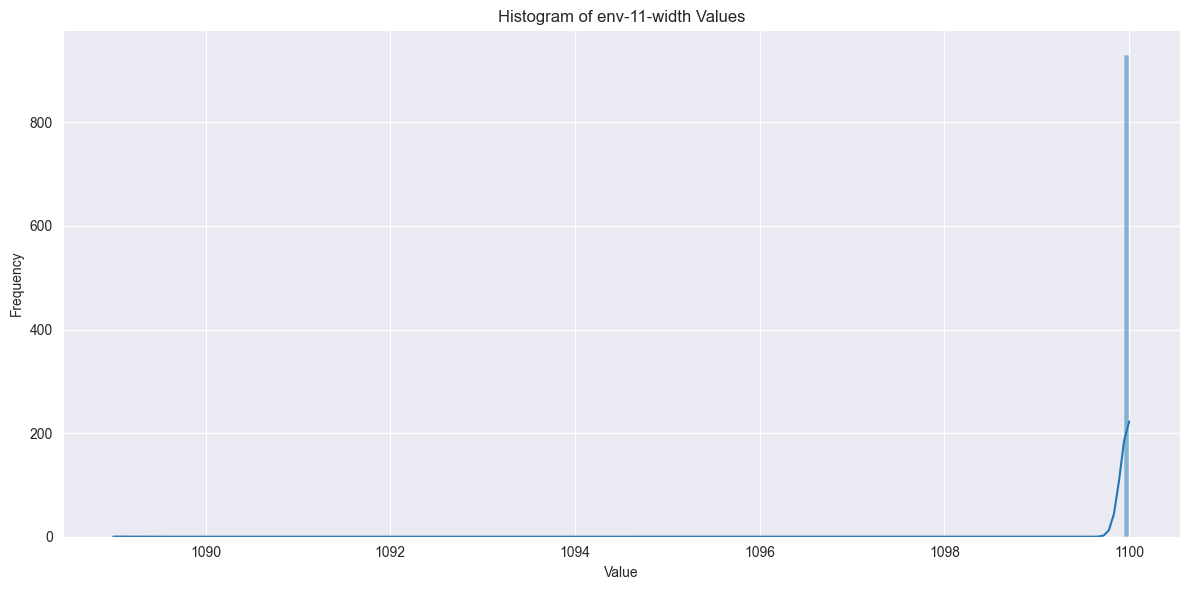

In [17]:
# query the database and plot the histogram of values for env-11-width
conn = sqlite3.connect(DB_PATH)
query = "SELECT session_id, value FROM css_attribute WHERE attribute = 'env-11-width'"
df_env_11_width = pd.read_sql(query, conn)
conn.close()
# get data only from unique session_id
df_env_11_width = df_env_11_width.drop_duplicates(subset=['session_id'])
# Convert the values to numeric, ignoring errors
df_env_11_width['value'] = pd.to_numeric(df_env_11_width['value'], errors='coerce')
# Drop NaN values
df_env_11_width = df_env_11_width.dropna()
# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(df_env_11_width['value'], bins=200, kde=True)
plt.title('Histogram of env-11-width Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [18]:
# write a sql query that will get all of the session_ids that don't have a record for env-11-width
conn = sqlite3.connect(DB_PATH)
query = """
SELECT DISTINCT session_id, attribute, value
FROM css_attribute
WHERE session_id NOT IN (
    SELECT DISTINCT session_id
    FROM css_attribute
    WHERE attribute = 'env-11-width'
)
"""
missing_session_ids = pd.read_sql(query, conn)
conn.close()
# remove attributes that are not os, os_version, browser, browser_version
missing_session_ids = missing_session_ids[missing_session_ids['attribute'].isin(['os', 'os_version', 'browser', 'browser_version'])]

# for each session_id get the values of os, os_version, browser, browser_version
missing_session_ids = missing_session_ids.groupby('session_id').agg(lambda x: ', '.join(x)).reset_index()
missing_session_ids


,session_id,attribute,value
0,5aea4aed-a2c7-4085-bacf-64caa824a75c,"browser, browser_version, os, os_version","firefox, 129.0, OS X, Big Sur"


In [19]:
# make a query that will find all of the records with source 'js' and select only distinct session_id
conn = sqlite3.connect(DB_PATH)
query = """
SELECT DISTINCT session_id
FROM css_attribute
WHERE source = 'js'
"""
js_session_ids = pd.read_sql(query, conn)
conn.close()


In [20]:
# get a list of all distinct attribute names that are from source 'js'
conn = sqlite3.connect(DB_PATH)
query = """
SELECT DISTINCT attribute
FROM css_attribute
WHERE source = 'js'
"""


In [21]:
# create a histogram of the values for each js attribute
js_attributes = pd.read_sql(query, conn)
conn.close()

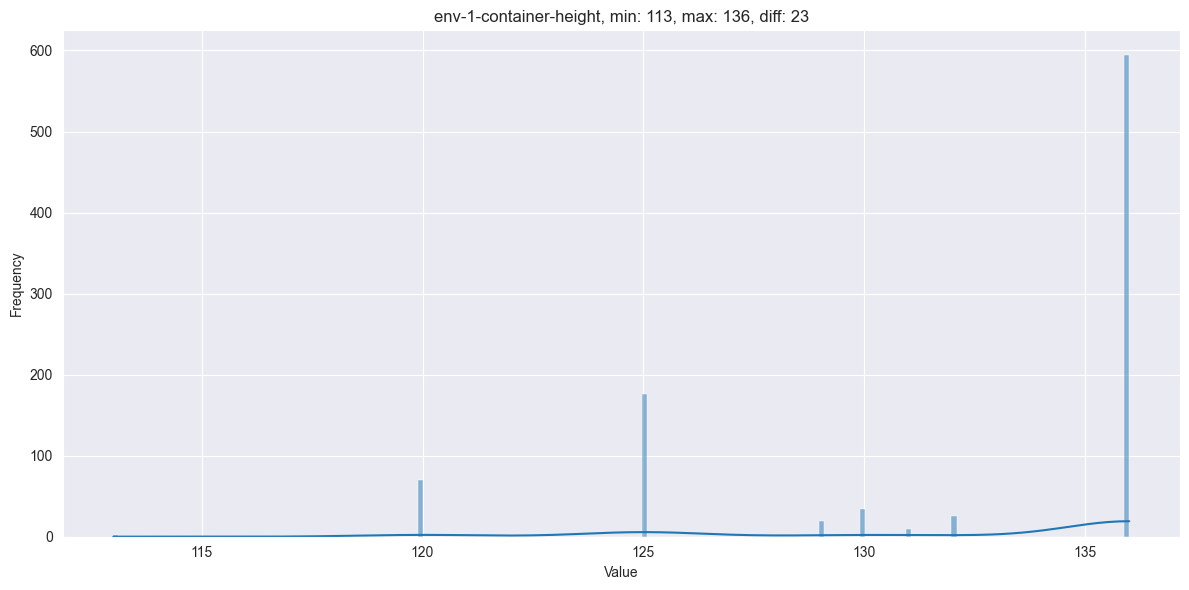

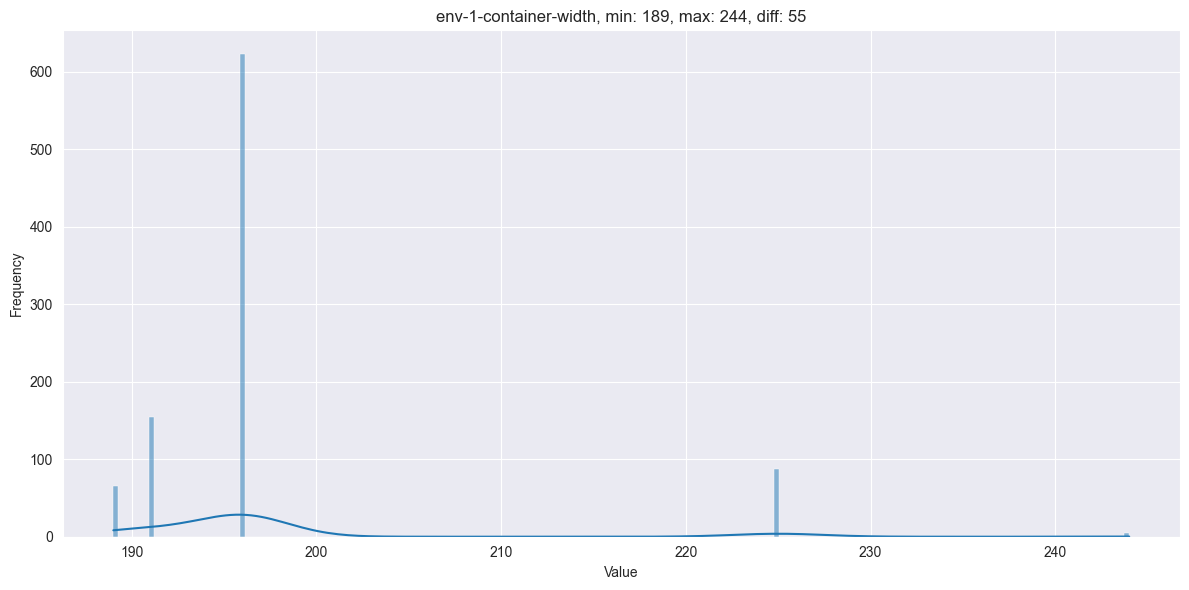

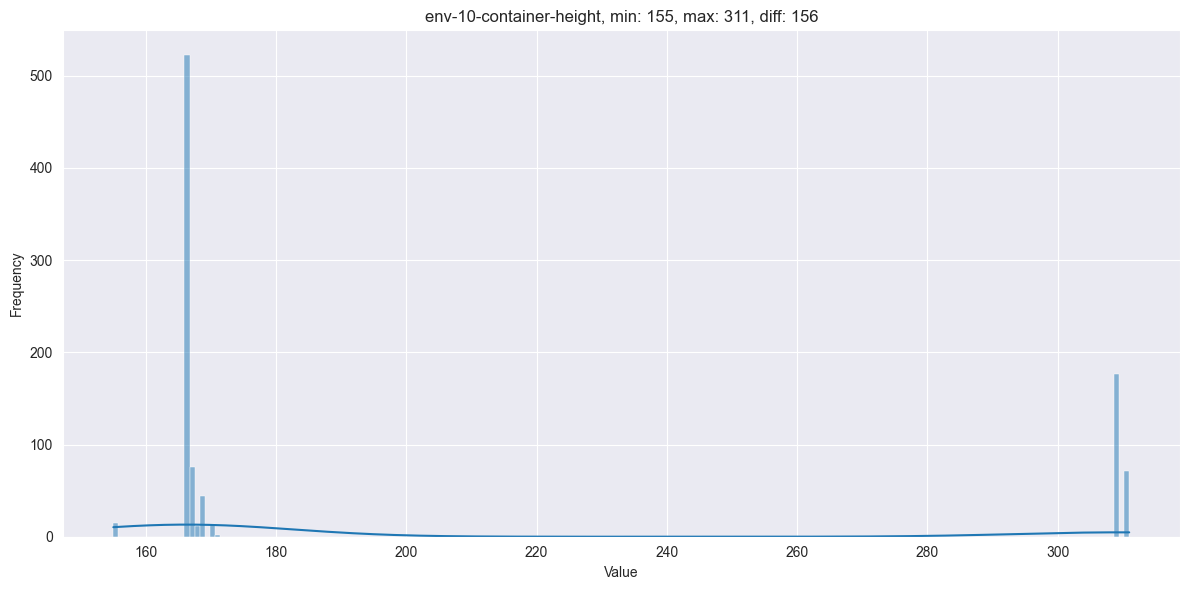

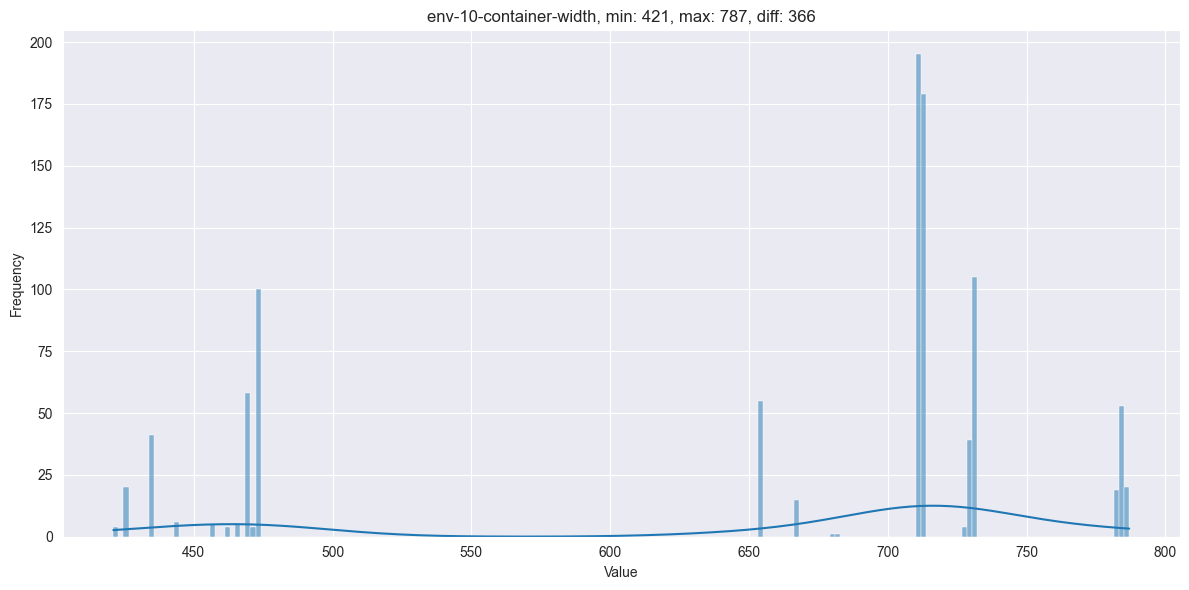

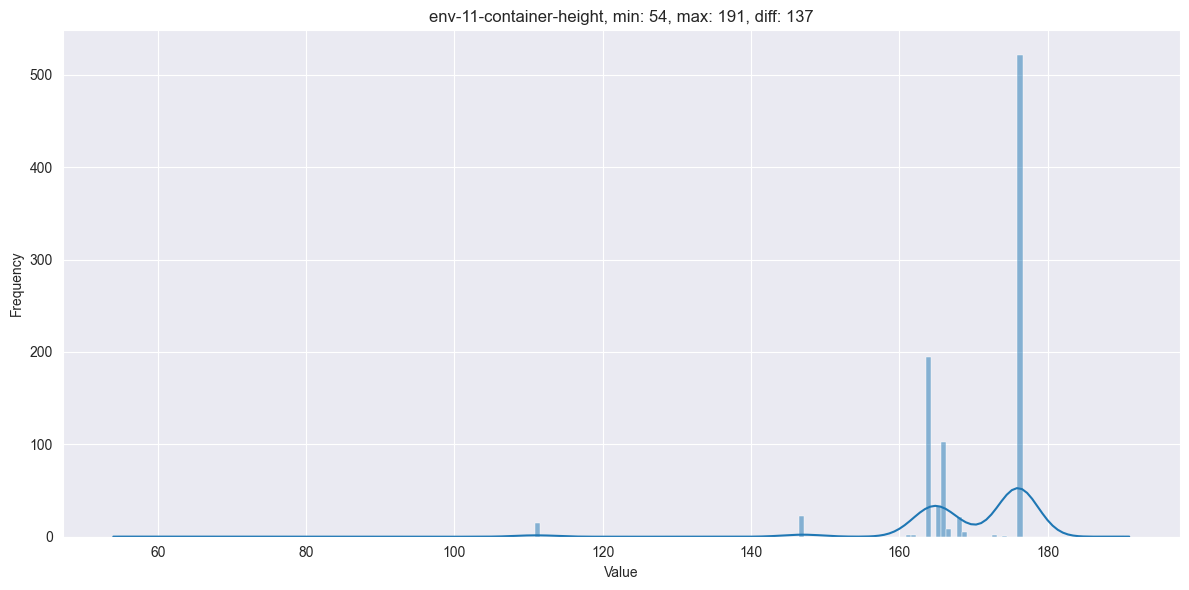

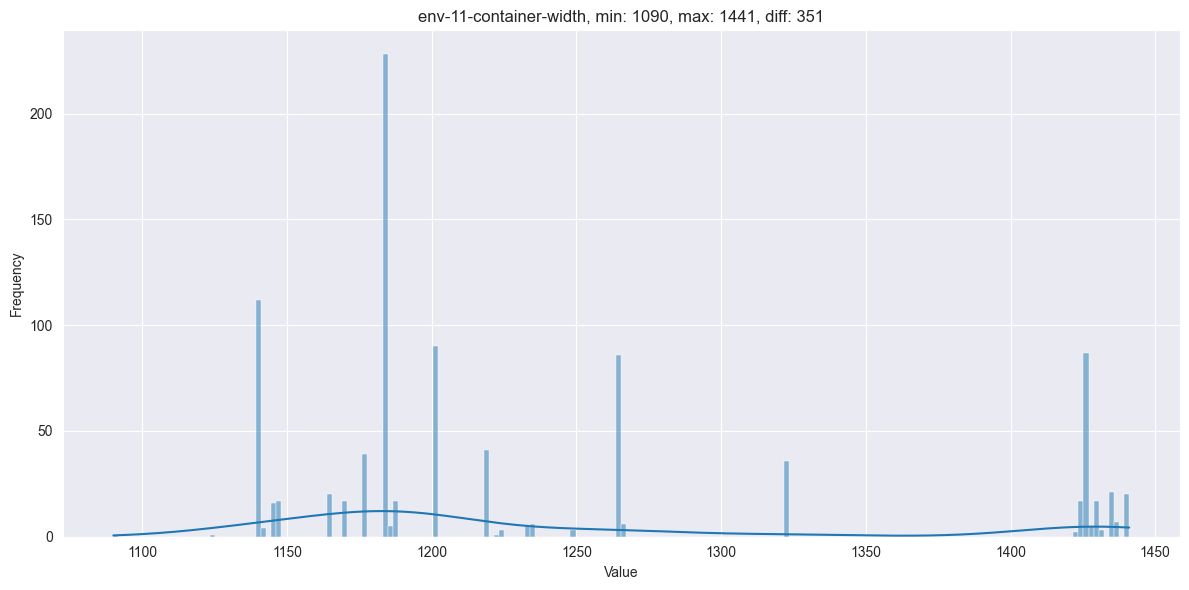

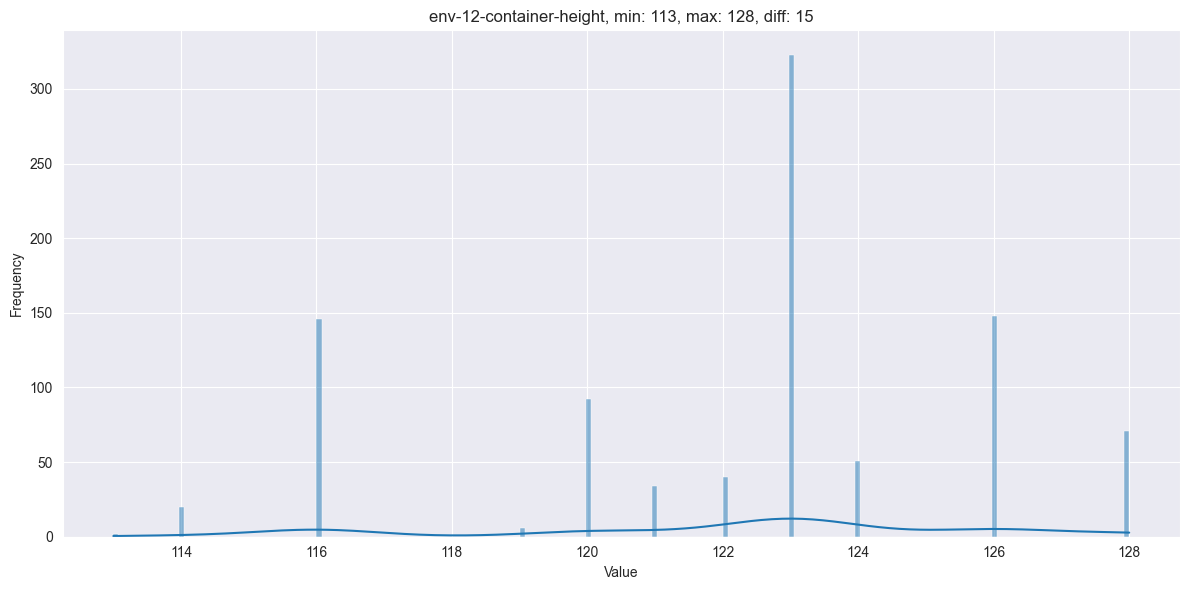

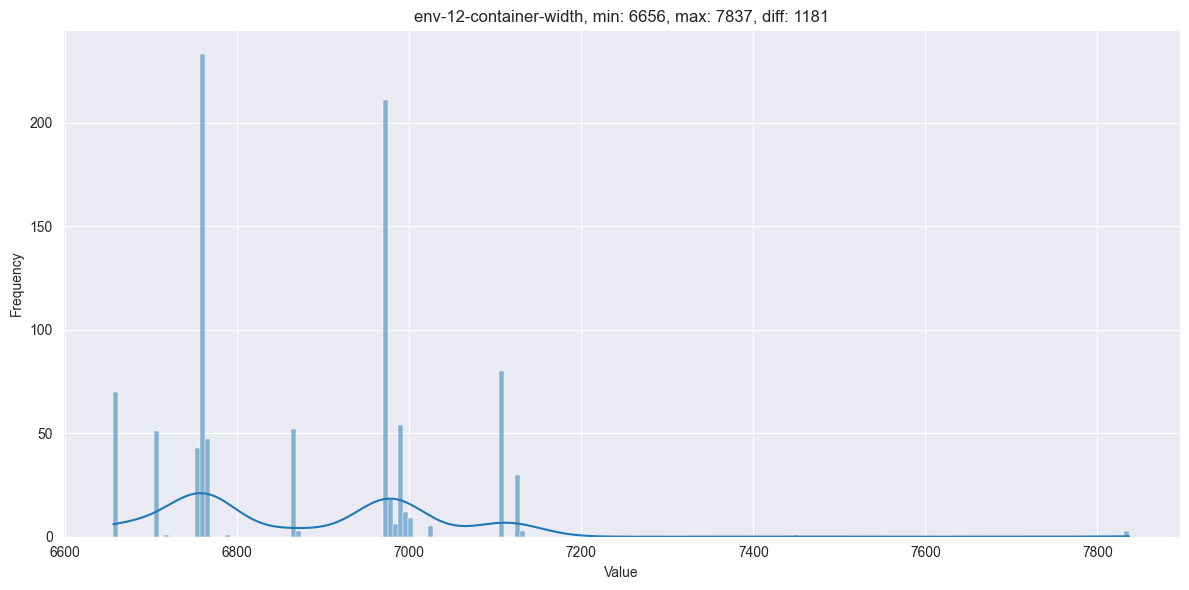

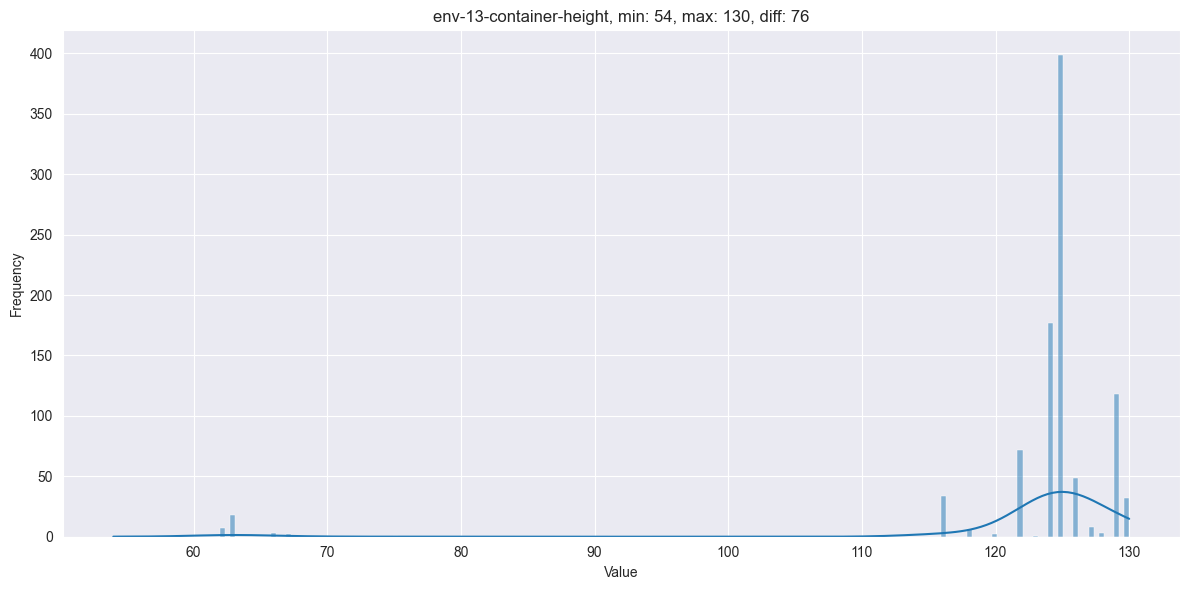

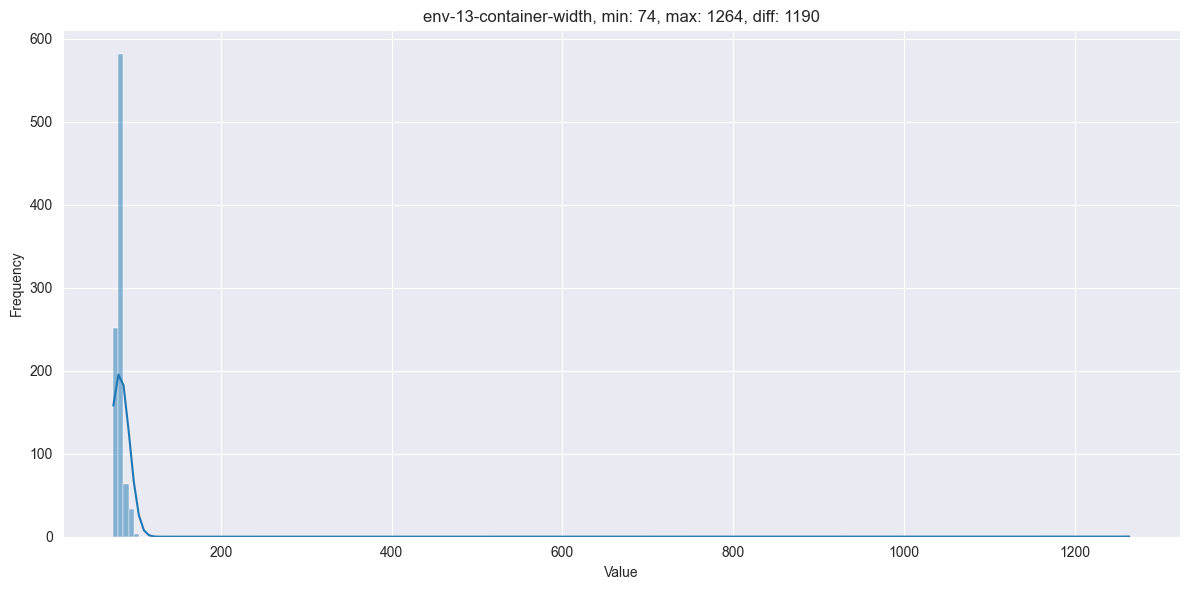

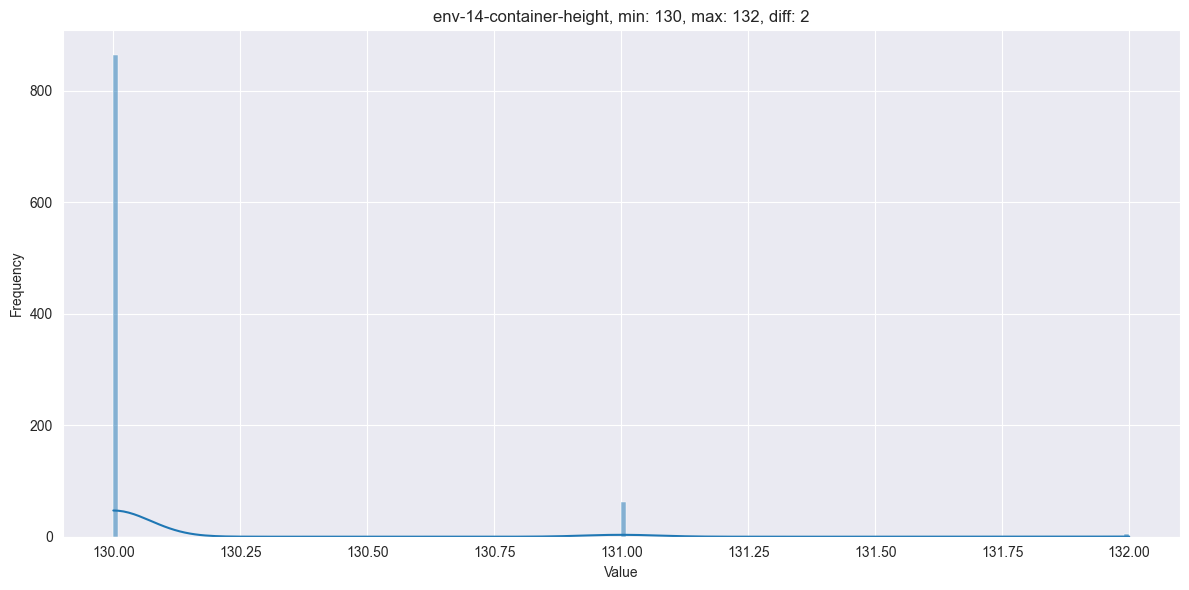

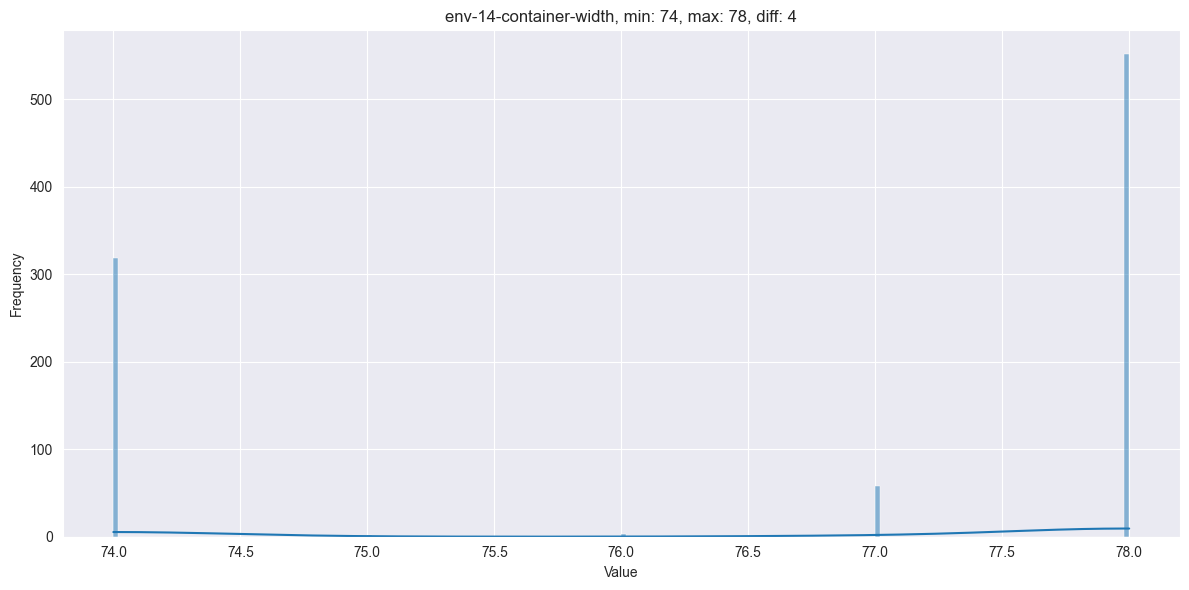

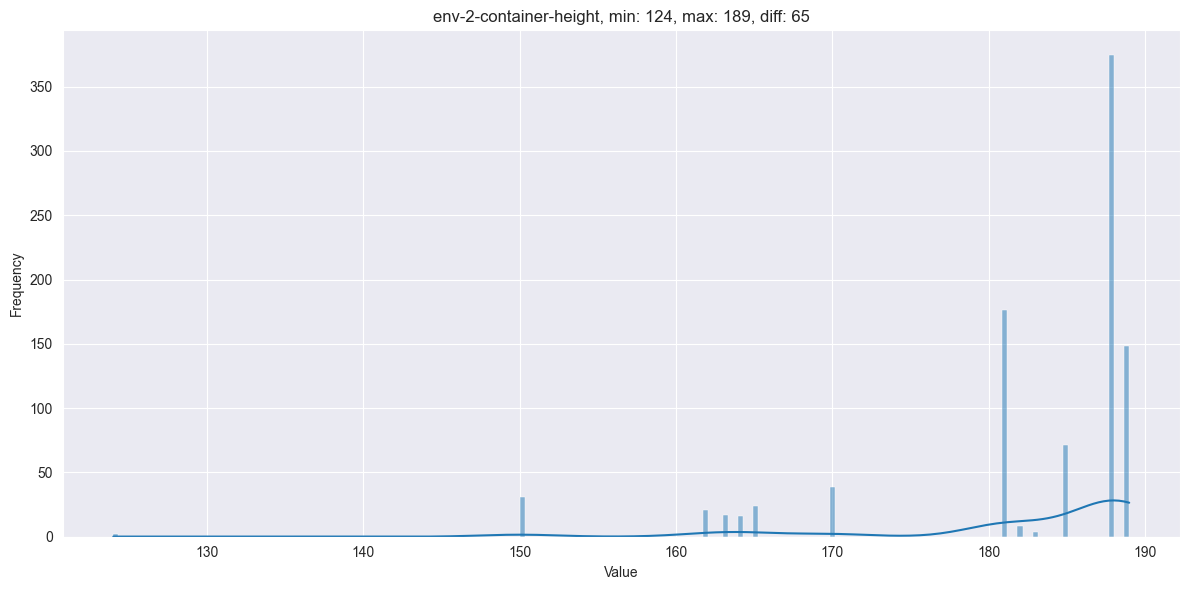

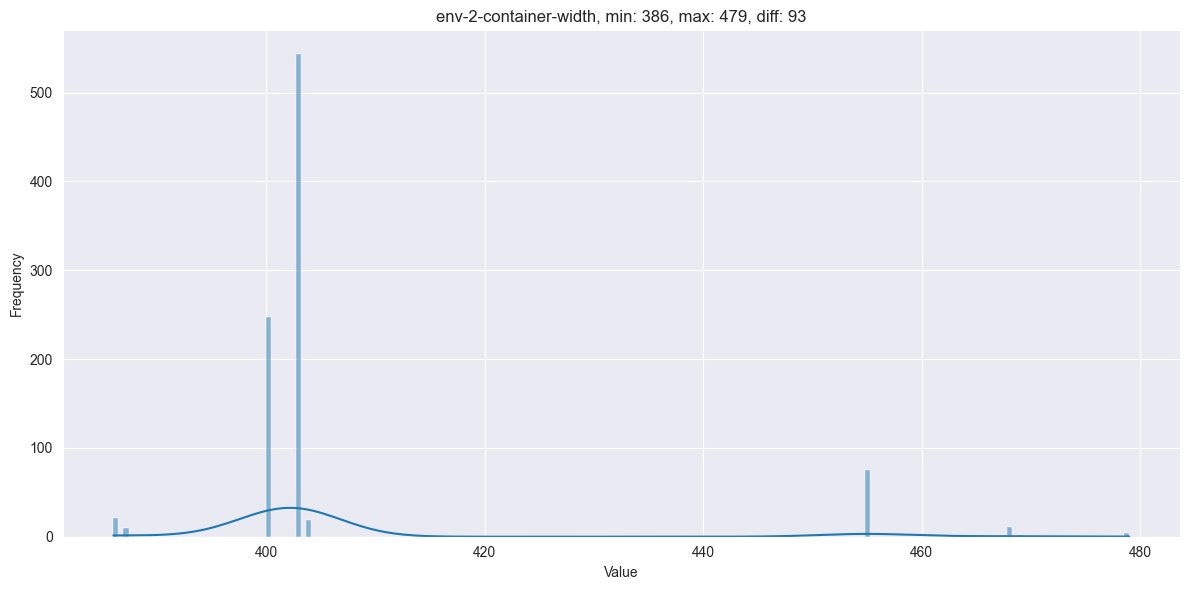

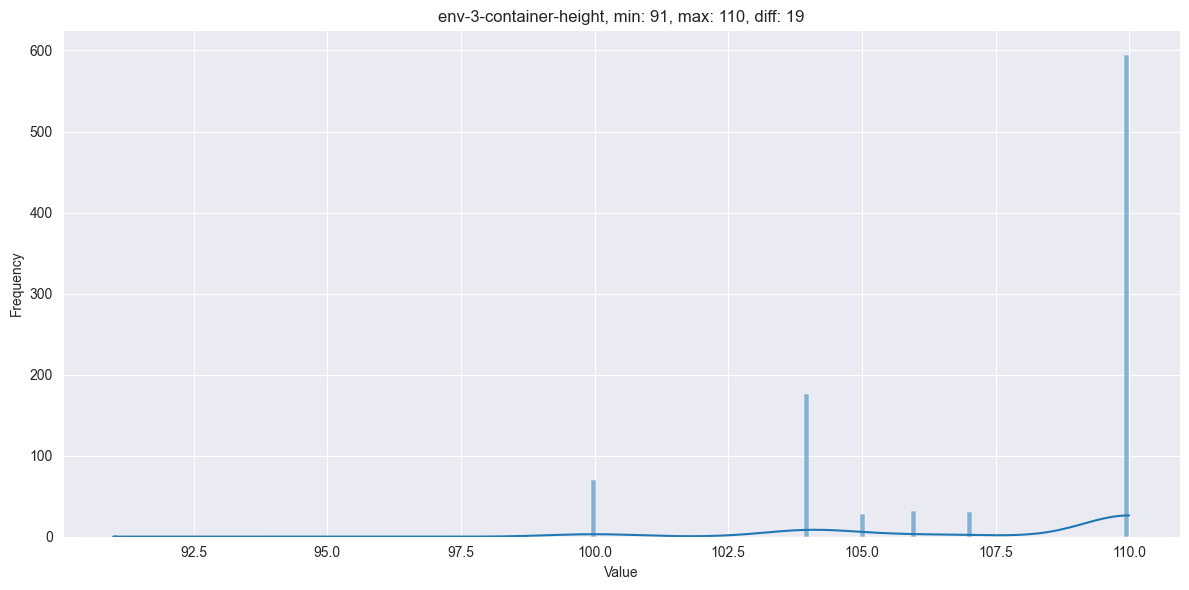

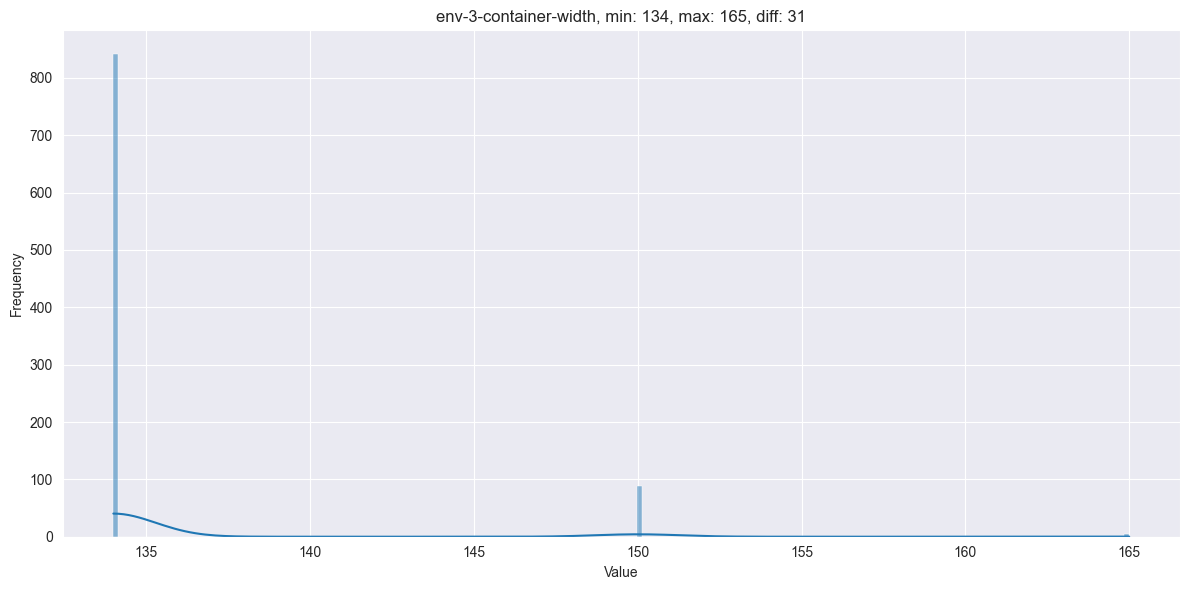

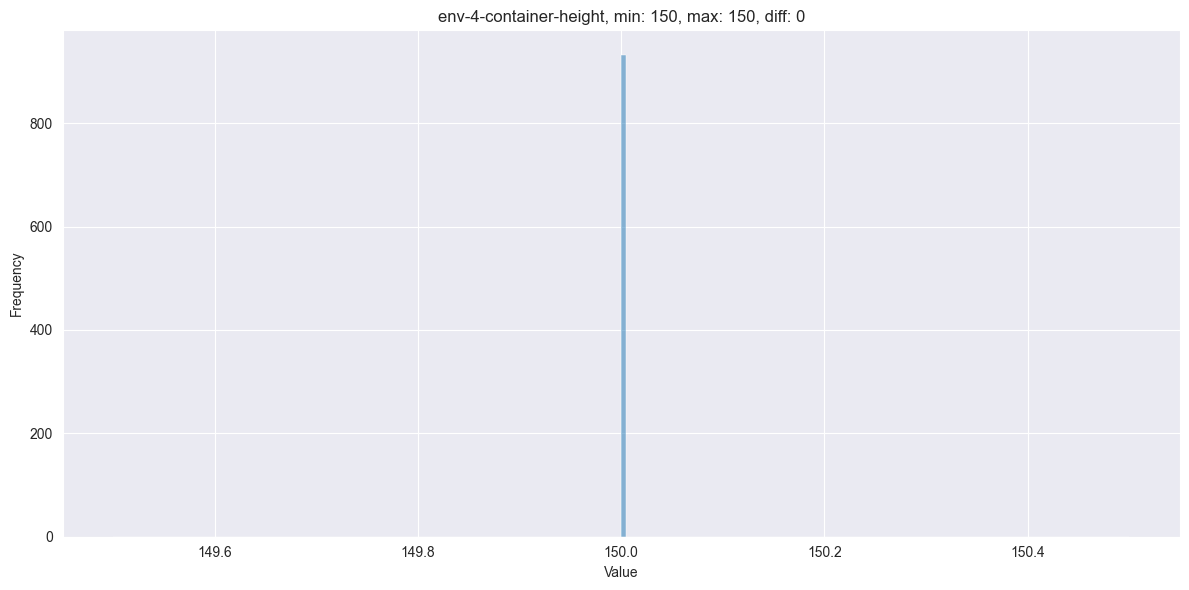

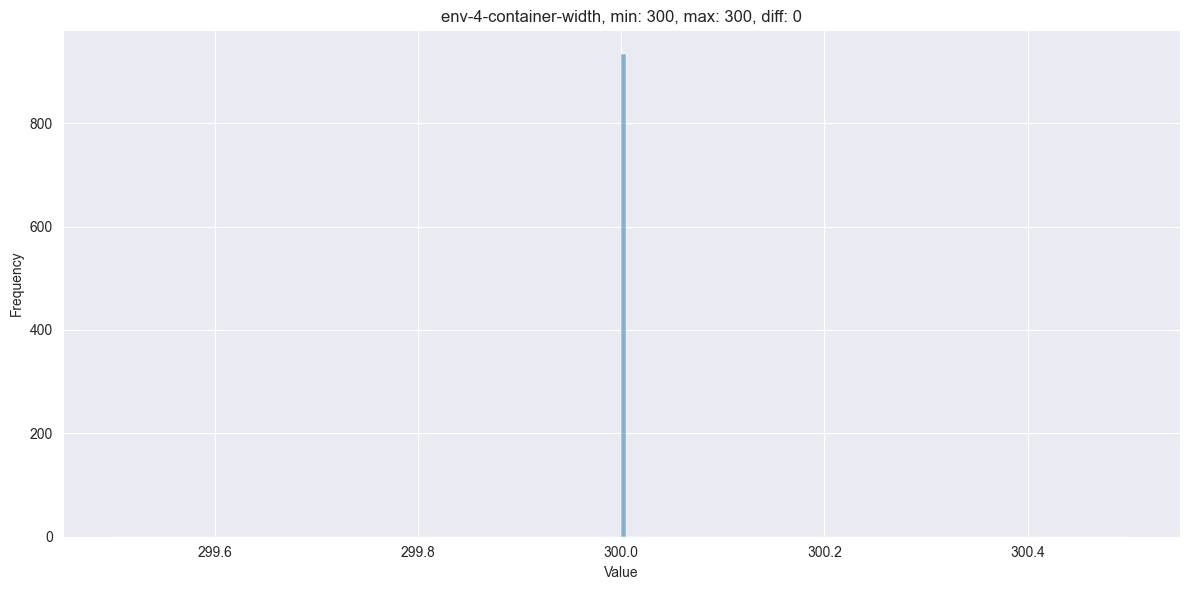

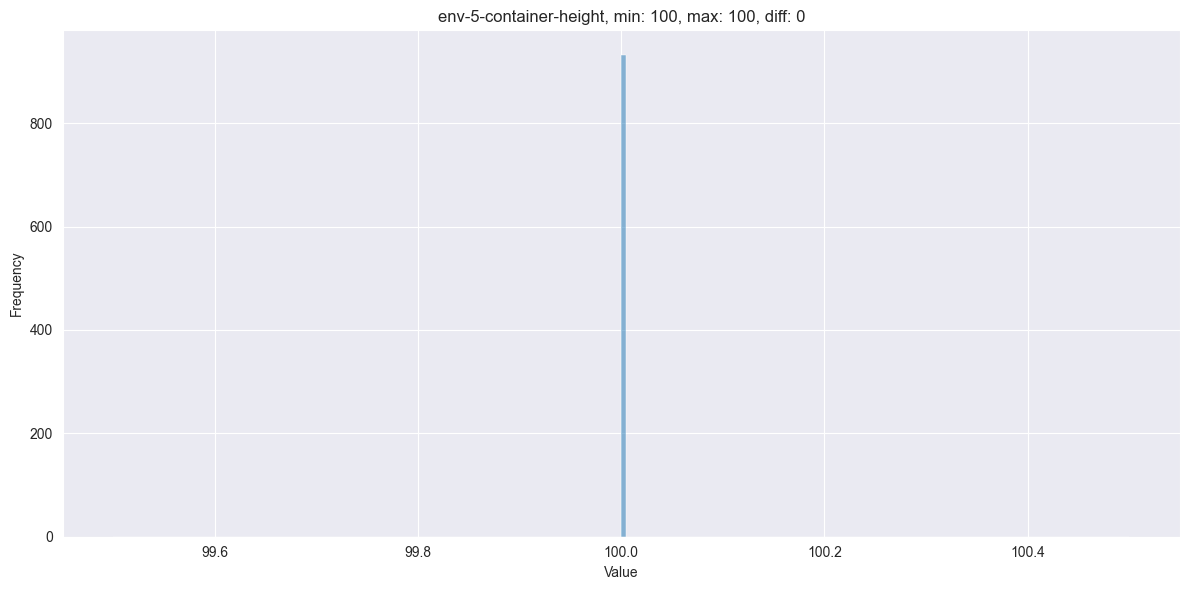

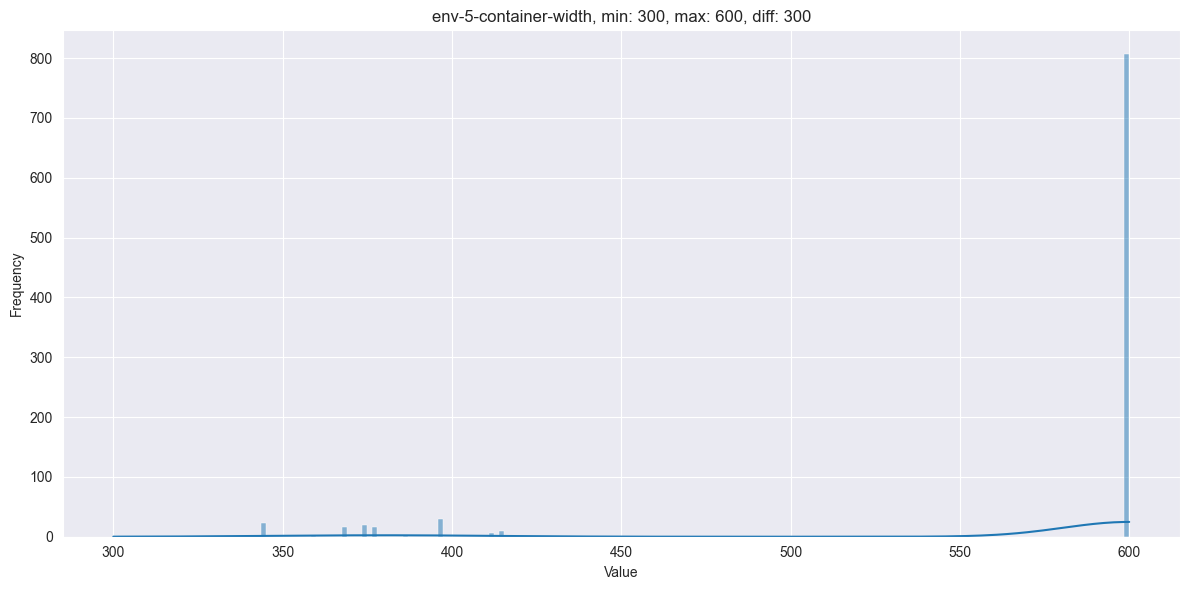

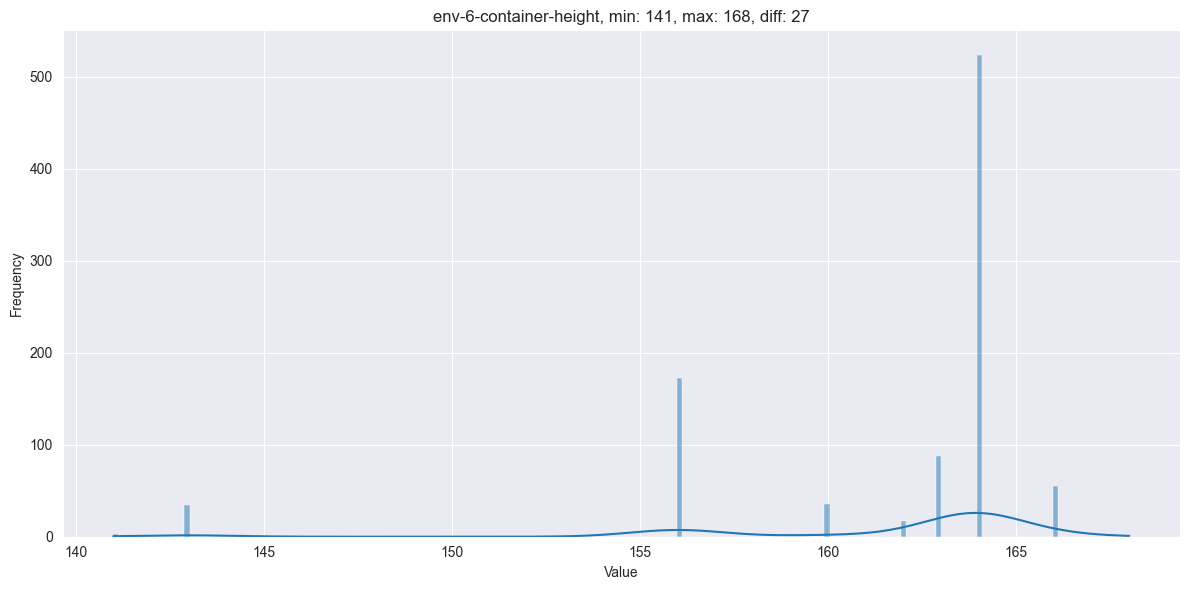

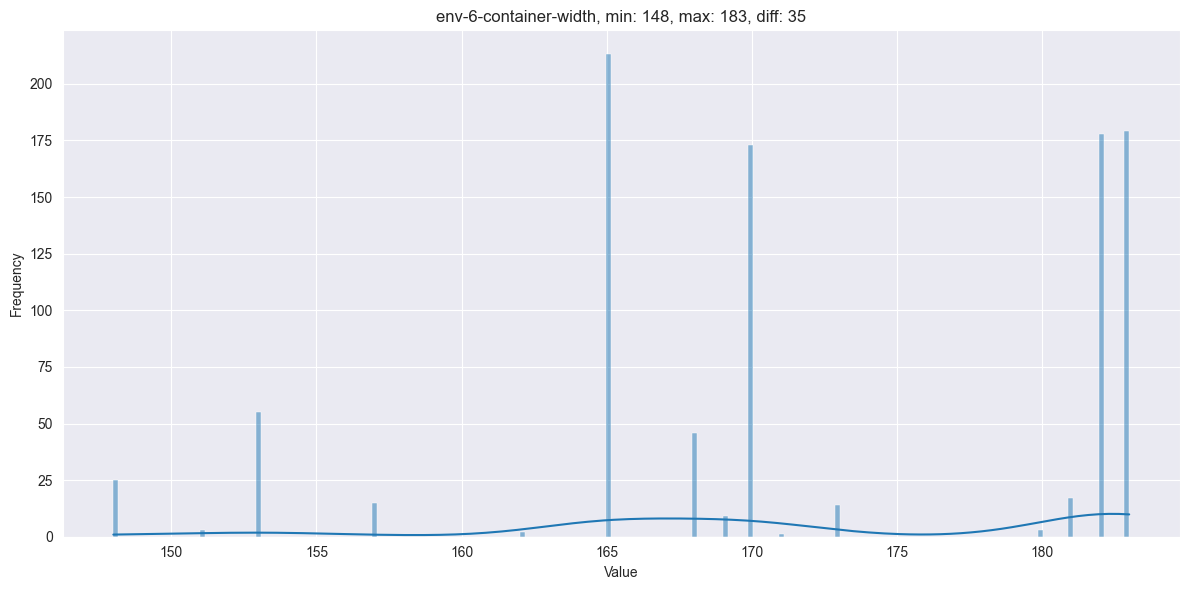

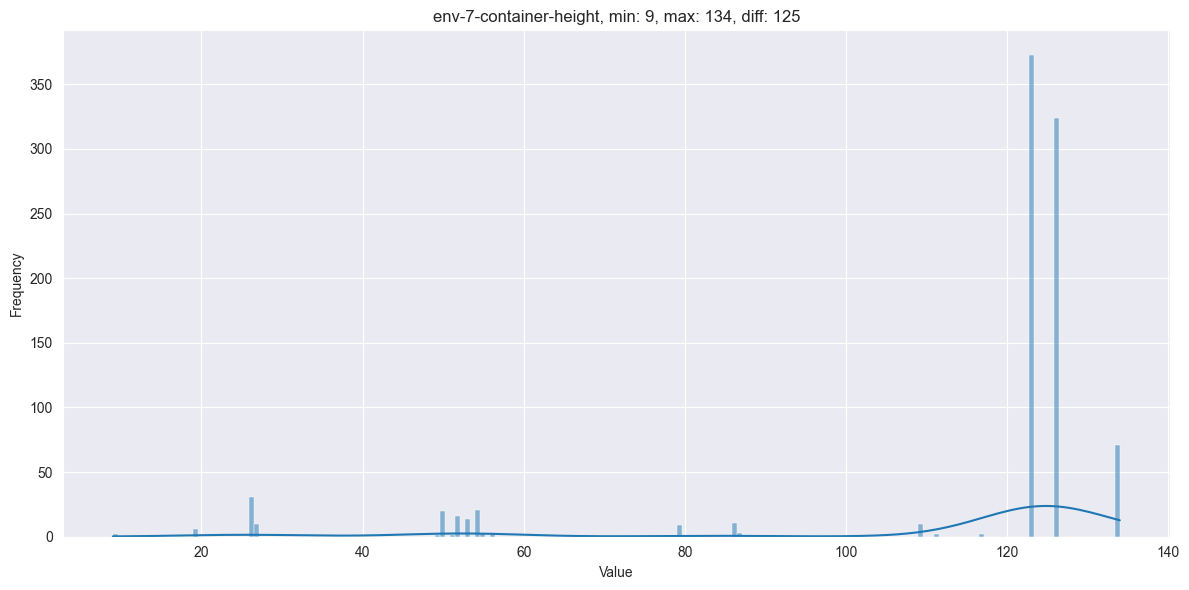

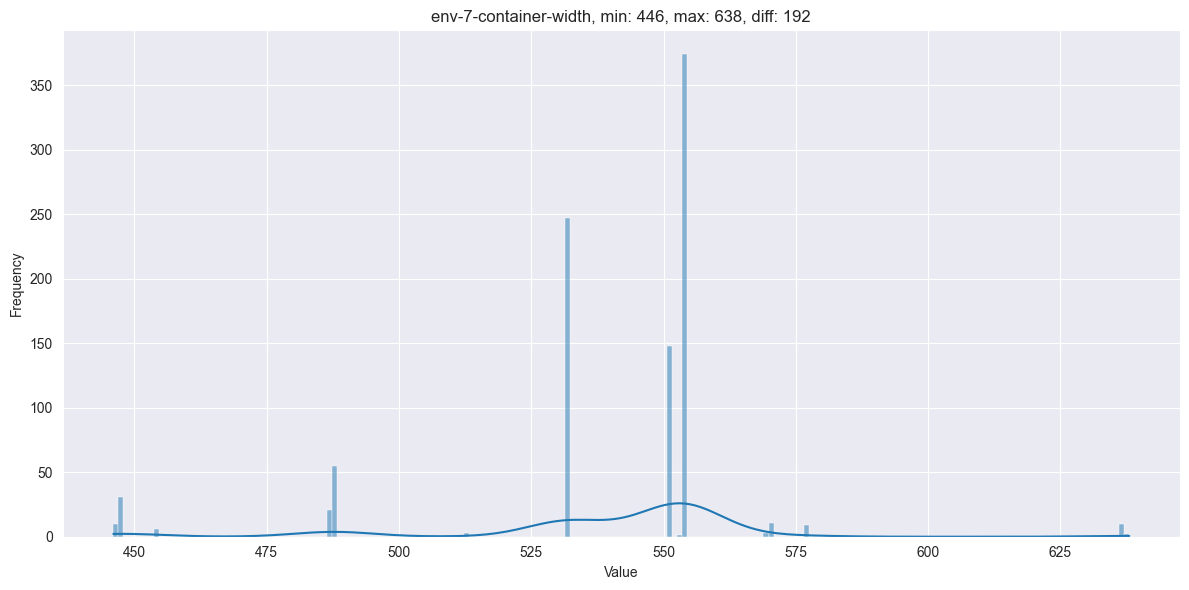

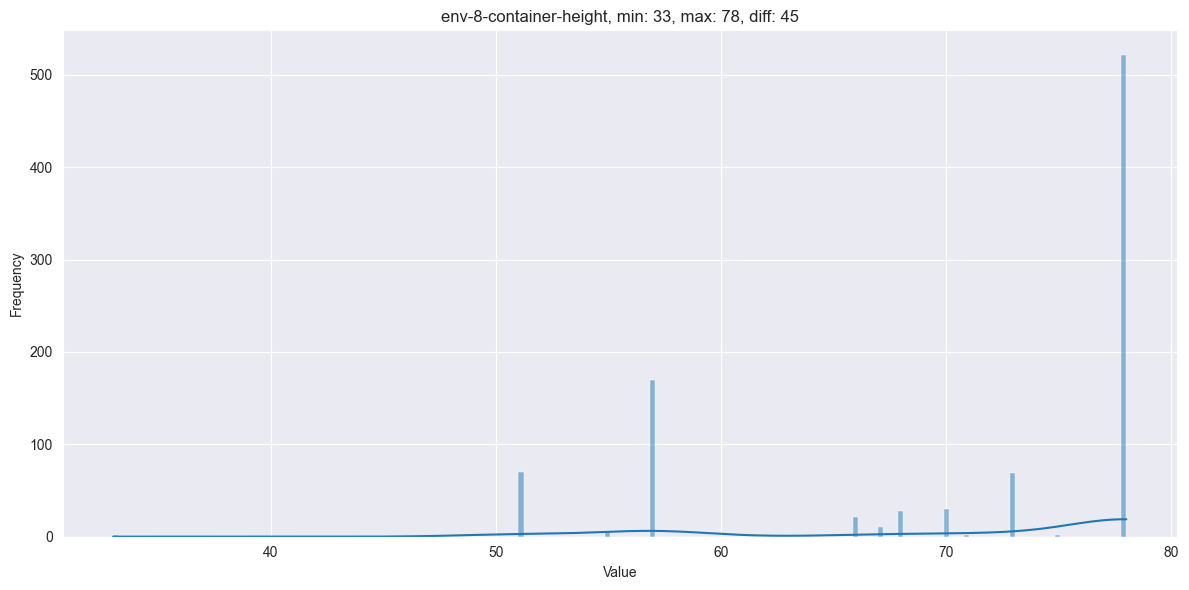

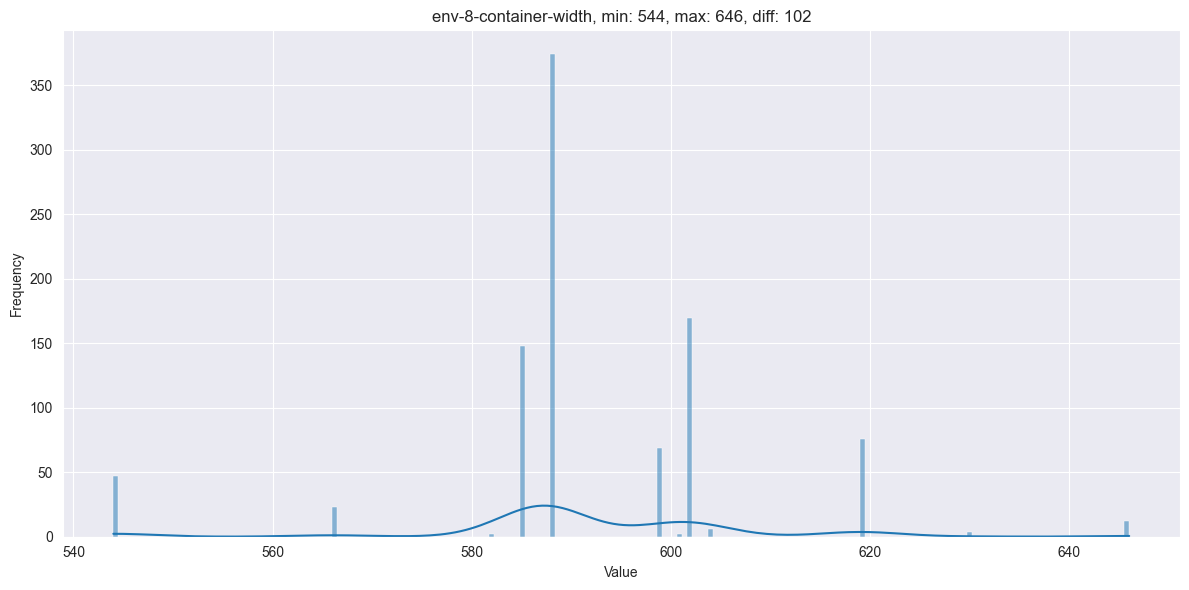

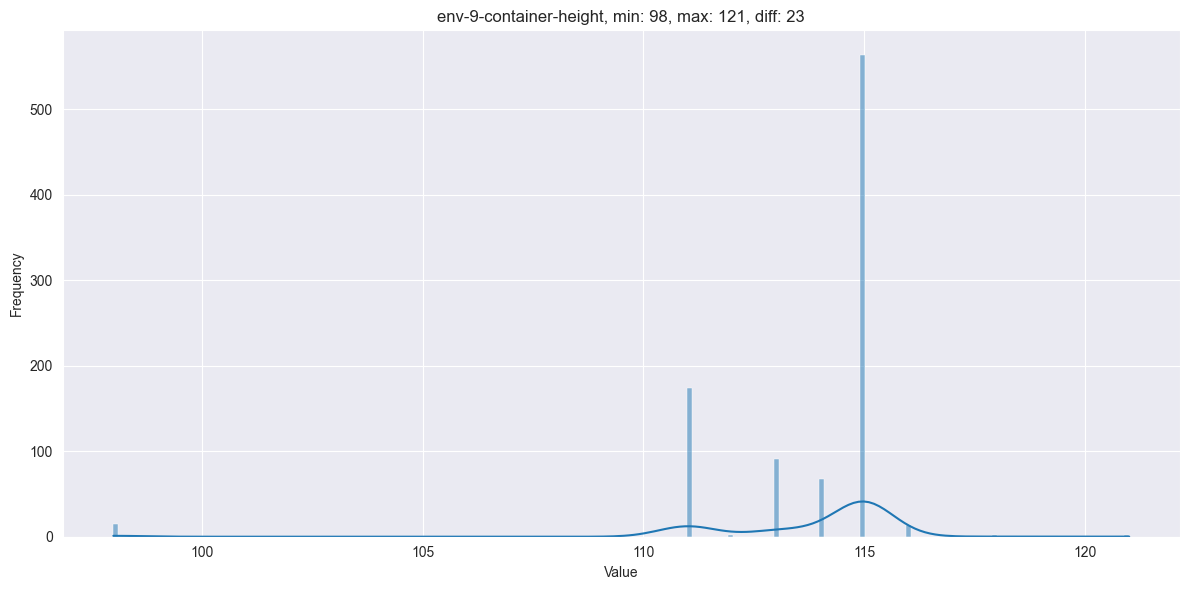

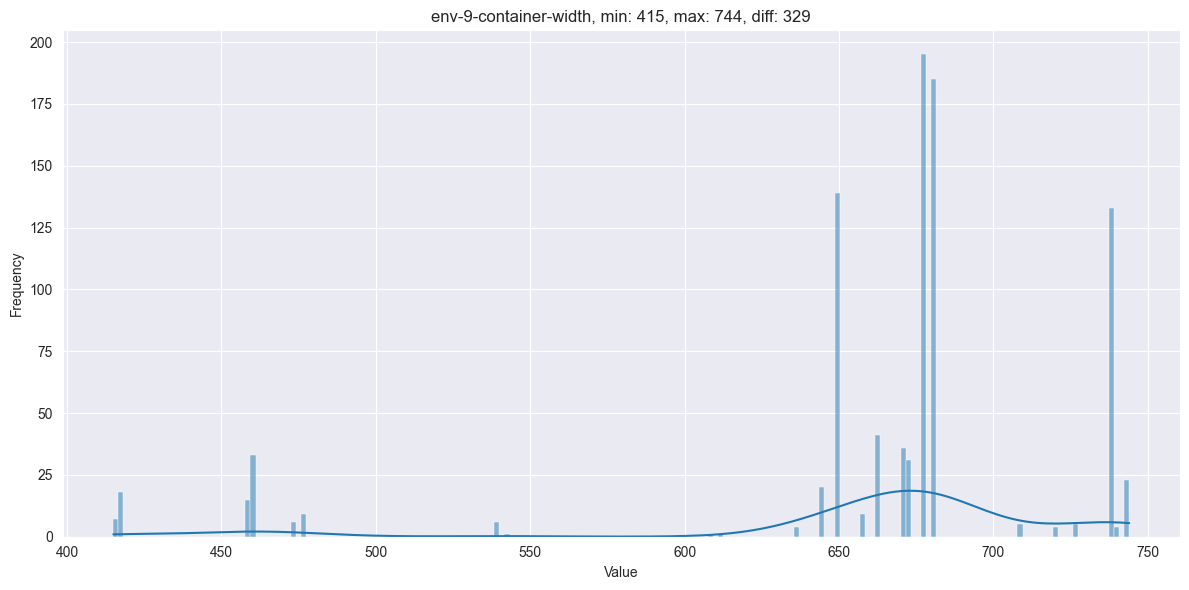

In [22]:
# sort js attrbutes alphatebicly by 'attribute'
js_attributes = js_attributes.sort_values(by=['attribute'])
# get all of the values for each js attribute
js_attributes_values = {}
for attr in js_attributes['attribute']:
    conn = sqlite3.connect(DB_PATH)
    query = f"""
    SELECT value
    FROM css_attribute
    WHERE attribute = '{attr}' AND source = 'js' AND session_id IN (
        SELECT DISTINCT session_id
        FROM css_attribute
        WHERE attribute = 'User-Agent'
    )
    """
    js_attributes_values[attr] = pd.read_sql(query, conn)
    conn.close()
    # remove duplicates
    # js_attributes_values[attr] = js_attributes_values[attr].drop_duplicates(subset=['value'])
    # convert to numeric
    js_attributes_values[attr]['value'] = pd.to_numeric(js_attributes_values[attr]['value'], errors='coerce')
    # drop NaN values
    js_attributes_values[attr] = js_attributes_values[attr].dropna()
    # max value
    max_value = js_attributes_values[attr].max().value
    min_value = js_attributes_values[attr].min().value
    # plot histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(js_attributes_values[attr]['value'], bins=200, kde=True)
    plt.title(f'{attr}, min: {min_value}, max: {max_value}, diff: {max_value - min_value}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [23]:
# for each of the js attributes get the max and min values across all sessions
js_attributes_min_max = {}
for attr in js_attributes['attribute']:
    conn = sqlite3.connect(DB_PATH)
    # query but find the min and max using pandas
    query = f"""
    SELECT attribute, value
    FROM css_attribute
    WHERE attribute = '{attr}' AND source = 'js'
    """

    temp_pd = pd.read_sql(query, conn)
    conn.close()

    temp_pd['value'] = pd.to_numeric(temp_pd['value'])
    # find min value in temp_pd
    min = temp_pd['value'].min()
    max = temp_pd['value'].max()
    print(f"Attribute: {attr}, min value: {min}, max value: {max}, difference: {max - min}")


Attribute: env-1-container-height, min value: 113, max value: 136, difference: 23
Attribute: env-1-container-width, min value: 189, max value: 244, difference: 55
Attribute: env-10-container-height, min value: 155, max value: 311, difference: 156
Attribute: env-10-container-width, min value: 421, max value: 787, difference: 366
Attribute: env-11-container-height, min value: 54, max value: 191, difference: 137
Attribute: env-11-container-width, min value: 1090, max value: 1441, difference: 351
Attribute: env-12-container-height, min value: 113, max value: 128, difference: 15
Attribute: env-12-container-width, min value: 6656, max value: 7837, difference: 1181
Attribute: env-13-container-height, min value: 54, max value: 130, difference: 76
Attribute: env-13-container-width, min value: 74, max value: 1264, difference: 1190
Attribute: env-14-container-height, min value: 130, max value: 132, difference: 2
Attribute: env-14-container-width, min value: 74, max value: 78, difference: 4
Attrib

In [24]:
# how many records with source 'js' there is
query = """
SELECT DISTINCT session_id, source
FROM css_attribute
WHERE source = 'js'"""
conn = sqlite3.connect(DB_PATH)
js_session_ids = pd.read_sql(query, conn)
conn.close()

js_session_ids['session_id'].count()

np.int64(933)

In [25]:
# todo zrobic skrypt do zmiany bazy z wiele rekordów dla jednej sesji, dla jeden wiers = jedna sesja, szczególnie do automatycznych testów

## Sprawdzanie jakie session_id są odpowiedzialne za outliery

In [26]:
attr = 'env-8-container-width'
conn = sqlite3.connect(DB_PATH)
query = f"""
SELECT session_id, attribute, value, source
FROM css_attribute
WHERE attribute = '{attr}' AND source = 'js'
"""
temp_pd = pd.read_sql(query, conn)
conn.close()

temp_pd['value'] = pd.to_numeric(temp_pd['value'])

# find value between 700 and 800
temp_pd = temp_pd[(temp_pd['value'] > 660)]
temp_pd

,session_id,attribute,value,source


## Przypadkowe requesty, z których nawet nie został zebrany User-Agent

In [27]:
# find all session_ids that don't have User-Agent attribute
conn = sqlite3.connect(DB_PATH)
query = """
SELECT DISTINCT session_id
FROM css_attribute
WHERE session_id NOT IN (
    SELECT DISTINCT session_id
    FROM css_attribute
    WHERE attribute = 'User-Agent'
)
"""
missing_session_ids = pd.read_sql(query, conn)
conn.close()
# remove duplicates
missing_session_ids = missing_session_ids.drop_duplicates(subset=['session_id'])

missing_session_ids

,session_id


## Urządzenia na których font detection nie działa

In [28]:

# find all session_ids that have more than 40 attributes 'font'
conn = sqlite3.connect(DB_PATH)
query = """
SELECT session_id, attribute, value, source
FROM css_attribute
WHERE attribute = 'font'
"""
font_session_ids = pd.read_sql(query, conn)
conn.close()

# remove duplicates
# font_session_ids = font_session_ids.drop_duplicates(subset=['session_id'])
# count the number of attributes for each session_id
font_session_ids_count = font_session_ids['session_id'].value_counts()
# filter the session_ids with more than 40 attributes
font_session_ids_count = font_session_ids_count[font_session_ids_count > 30]
font_session_ids_count

session_id
47e04a97-26b2-4251-8ec6-3dd3a9b2c3b5    49
7729186e-1678-4d5c-96a6-c52b342dc268    49
1a6ede18-7bbe-4a62-a30c-6030330ca1b4    49
Name: count, dtype: int64

## Urządzenia na których nie działa `@container` w css

In [29]:
# find all session_ids that have only 2 attributes with source 'css'
conn = sqlite3.connect(DB_PATH)
query = """
SELECT session_id, attribute, value, source
FROM css_attribute
WHERE source = 'css' and session_id IN (
        SELECT DISTINCT session_id
        FROM css_attribute
        WHERE attribute = 'User-Agent'
    )
"""
css_session_ids = pd.read_sql(query, conn)
conn.close()
# count the number of attributes for each session_id
css_session_ids_count = css_session_ids['session_id'].value_counts()
# css_session_ids_count
# filter the session_ids with only 2 attributes
css_session_ids_count = css_session_ids_count[css_session_ids_count == 2]
css_session_ids_count

Series([], Name: count, dtype: int64)

In [30]:
# find all session_ids that don't have any attributes with source 'browserstack'
conn = sqlite3.connect(DB_PATH)
query = """
SELECT session_id, attribute, value, source
FROM css_attribute
WHERE session_id NOT IN (
    SELECT DISTINCT session_id
    FROM css_attribute
    WHERE source = 'browserstack'
)
"""
missing_session_ids = pd.read_sql(query, conn)
conn.close()
# remove duplicates
missing_session_ids = missing_session_ids.drop_duplicates(subset=['session_id'])

missing_session_ids

,session_id,attribute,value,source
0,17d0e6a1-5b9c-4899-a7c1-09483a439b53,User-Agent,curl/8.11.1,css
1,356670d5-9f02-4ce7-8cef-5fbeda6c1fce,User-Agent,"Ruby, Mozilla/5.0 (Macintosh; Intel Mac OS X 1...",css
2,4458d75b-71f5-4e40-8de7-020176a0691b,User-Agent,"Ruby, Mozilla/5.0 (Macintosh; Intel Mac OS X 1...",css
3,ca903639-973c-494b-9fd8-30314d6c1caa,User-Agent,"Ruby, Mozilla/5.0 (Macintosh; Intel Mac OS X 1...",css
4,e75125f0-c5e4-4494-86a2-e7f48ffd1cd1,User-Agent,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,css
...,...,...,...,...
841,5faf95a9-0473-4d43-82a5-2ebc1c6480e3,User-Agent,"Ruby, Mozilla/5.0 (Macintosh; Intel Mac OS X 1...",css
842,d8cec2f8-7997-4b7f-be36-7cbcab0e12ee,User-Agent,"Ruby, Mozilla/5.0 (Macintosh; Intel Mac OS X 1...",css
843,832c9082-4fb5-415c-9e78-46c2e6cffef2,User-Agent,"Ruby, Mozilla/5.0 (Macintosh; Intel Mac OS X 1...",css
844,88ae9ed5-4ecb-4c4d-b1fd-6832f36a713b,User-Agent,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,css
